<a href="https://colab.research.google.com/github/Yashwanth2025/proto/blob/main/proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import math
import re
import shutil
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT="/content/drive/MyDrive/Dataset_BUSI_with_GT"
n={}
for dir in os.listdir(ROOT):
  n[dir]=len(os.listdir(os.path.join(ROOT,dir)))
print(n)

{'normal': 276, 'benign': 891, 'malignant': 421}


In [4]:
def mkfol(p,r):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(ROOT):
      os.mkdir(os.path.join("./"+p,dir))
      l=[]
      for i in os.listdir(os.path.join(ROOT,dir)):
        if not re.fullmatch(".*mask.*",i):
          l.append(i)
      for img in np.random.choice(a=l,size=math.floor(r*len(l))-2,replace=False):
        o = os.path.join(ROOT,dir,img)
        d = os.path.join("./"+p,dir)
        shutil.copy(o,d)
  else:
    print(f"{p} already exists.")

In [5]:
mkfol("train",0.7)
mkfol("test",0.15)
mkfol("val",0.15)

In [6]:
from keras_preprocessing.image import image_data_generator
def ppi(p):
  i = ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)
  I = i.flow_from_directory(directory=p,target_size=(500,500),batch_size=32)
  return I
def ppi2(p):
  i = ImageDataGenerator(rescale=1/255)
  I = i.flow_from_directory(directory=p,target_size=(500,500),batch_size=32)
  return I


In [7]:
train_images=ppi("./train")
test_images=ppi2("./test")
val_images=ppi2("./val")

Found 542 images belonging to 3 classes.
Found 110 images belonging to 3 classes.
Found 110 images belonging to 3 classes.


In [8]:
from keras.layers.core.dropout import Dropout
from keras.layers.core.flatten import Flatten
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(rate=0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(layers.Dense(3))
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 64)       0

In [9]:
history = model.fit_generator(generator=train_images, epochs=10, verbose = 1, validation_data=val_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
17/17 [==============================] - 43s 2s/step - loss: 3.2306 - accuracy: 0.1974 - val_loss: 3.8097 - val_accuracy: 0.1636
Epoch 2/10
17/17 [==============================] - 30s 2s/step - loss: 7.5058 - accuracy: 0.2325 - val_loss: 4.5123 - val_accuracy: 0.5727
Epoch 3/10
17/17 [==============================] - 30s 2s/step - loss: 4.5782 - accuracy: 0.5295 - val_loss: 4.2883 - val_accuracy: 0.5727
Epoch 4/10
17/17 [==============================] - 30s 2s/step - loss: 4.4966 - accuracy: 0.4022 - val_loss: 4.2493 - val_accuracy: 0.1636
Epoch 5/10
17/17 [==============================] - 30s 2s/step - loss: 5.2459 - accuracy: 0.2232 - val_loss: 4.2493 - val_accuracy: 0.1636
Epoch 6/10
17/17 [==============================] - 30s 2s/step - loss: 8.4996 - accuracy: 0.1734 - val_loss: 11.8688 - val_accuracy: 0.1636
Epoch 7/10
17/17 [==============================] - 30s 2s/step - loss: 6.5569 - accuracy: 0.1753 - val_loss: 2.6375 - val_accuracy: 0.1636
Epoch 8/10
17/17 [=

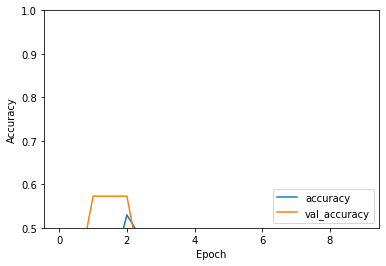

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [11]:
loss,acc = model.evaluate_generator(test_images,verbose=2)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


4/4 - 1s - loss: 2.6375 - accuracy: 0.1636 - 1s/epoch - 322ms/step
0.16363635659217834
